In [2]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

In [4]:
sns.set(style='whitegrid', palette='deep', font_scale=1.2)
file_path = "C:/Users/LENOVO/Desktop/ab_data.csv"
df = pd.read_csv(file_path)

In [5]:
print("Data Shape:", df.shape)
df.head()

Data Shape: (294478, 5)


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [7]:
# Check duplicate user_id
df[df["user_id"].duplicated()]

,user_id,timestamp,group,landing_page,converted
2656,698120,2017-01-15 17:13:42.602796,control,old_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0
7500,899953,2017-01-07 03:06:54.068237,control,new_page,0
8036,790934,2017-01-19 08:32:20.329057,treatment,new_page,0
10218,633793,2017-01-17 00:16:00.746561,treatment,old_page,0
...,...,...,...,...,...
294308,905197,2017-01-03 06:56:47.488231,treatment,new_page,0
294309,787083,2017-01-17 00:15:20.950723,control,old_page,0
294328,641570,2017-01-09 21:59:27.695711,control,old_page,0
294331,689637,2017-01-13 11:34:28.339532,control,new_page,0


In [8]:
df[df["user_id"]==698120]

,user_id,timestamp,group,landing_page,converted
988,698120,2017-01-22 07:09:37.540970,control,new_page,0
2656,698120,2017-01-15 17:13:42.602796,control,old_page,0


In [9]:
# Check if there is mismatch between group and landing_page
df_mismatch = df[(df["group"]=="treatment")&(df["landing_page"]=="old_page")
                |(df["group"]=="control")&(df["landing_page"]=="new_page")]
n_mismatch = df_mismatch.shape[0]
print(f"The number of mismatched rows:{n_mismatch} rows" )
print("Percent of mismatched rows:%.2f%%" % (n_mismatch/df.shape[0]*100))

The number of mismatched rows:3893 rows
Percent of mismatched rows:1.32%


In [12]:
df2 = df[(df["group"]=="treatment")&(df["landing_page"]=="new_page")
                |(df["group"]=="control")&(df["landing_page"]=="old_page")]

In [13]:
df2[df2["user_id"].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
df2[df2["user_id"]==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [15]:
df2.drop_duplicates(subset="user_id",inplace=True) 

In [16]:
df2.shape

(290584, 5)

In [17]:
# Conversion Rate
df_counts = pd.DataFrame({"Control_COUNT": df2[df2.group=="control"].converted.value_counts(),
              "Treatment_COUNT": df2[df2.group=="treatment"].converted.value_counts(),
              "Control_RATIO": df2[df2.group=="control"].converted.value_counts()/ len(df2[df2.group=="control"]),
              "Trement_RATIO": df2[df2.group=="treatment"].converted.value_counts() / len(df2[df2.group=="treatment"])})
df_counts

,Control_COUNT,Treatment_COUNT,Control_RATIO,Trement_RATIO
converted,,,,
0,127785,128046,0.879614,0.881192
1,17489,17264,0.120386,0.118808


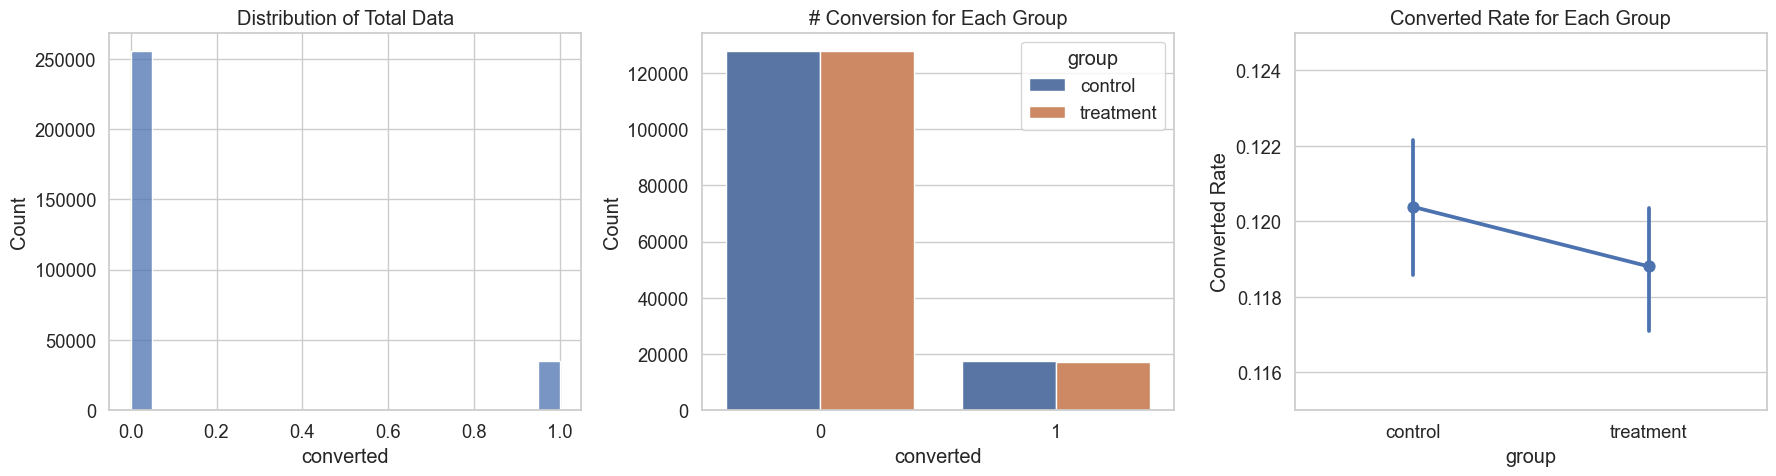

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ① histplot
sns.histplot(x="converted", data=df2, ax=axes[0])
axes[0].set_title("Distribution of Total Data")
axes[0].set_ylabel("Count")

# ② countplot
sns.countplot(x="converted", data=df2, hue="group", ax=axes[1])
axes[1].set_title("# Conversion for Each Group")
axes[1].set_ylabel("Count")

# ③ pointplot
sns.pointplot(x="group", y="converted", data=df2, ax=axes[2])
axes[2].set_ylim([0.115, 0.125])  # 시각적으로 미세한 차이 강조
axes[2].set_title("Converted Rate for Each Group")
axes[2].set_ylabel("Converted Rate")

plt.tight_layout()
plt.show()

In [22]:
table = df_counts.iloc[:,0:2].to_numpy()
table

array([[127785, 128046],
       [ 17489,  17264]], dtype=int64)

In [23]:
# chi-squared test 
stat, p, dof, expected = stats.chi2_contingency(table)
print("fredoom of degree=%d"% dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1-prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

fredoom of degree=1
[[127899.65274757 127931.34725243]
 [ 17374.34725243  17378.65274757]]
probability=0.950, critical=3.841, stat=1.704
Independent (fail to reject H0)
significance=0.050, p=0.192
Independent (fail to reject H0)


In [24]:
# Fishers exact test on the data
odd_ratio, p_value = stats.fisher_exact(table, alternative="two-sided")
print("odd ratio is : " + str(odd_ratio))
print("p_value is : " + str(p_value))
if p_value <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

odd ratio is : 0.9851226640350362
p_value is : 0.19047706765708894
Independent (fail to reject H0)


In [25]:
def AB_testing(dataframe, group, metric):
    
    # Split groups
    group_c = dataframe[dataframe[group] == "control"][metric]
    group_t = dataframe[dataframe[group] == "treatment"][metric]
    
    size = dataframe.shape[0]  
    table = pd.DataFrame({"C_COUNT": group_c.value_counts(),
              "T_COUNT": group_t.value_counts()}).to_numpy()
    
    if size < 1000:
        # Fisher Exact Test
        odd_ratio, p_value = stats.fisher_exact(table, alternative="two-sided")
    else:
        # Pearson Chi Square Test
        stat, p_value, dof, expected = stats.chi2_contingency(table)
    # Result
    temp = pd.DataFrame({
        "Test":[size<1000],
        "P_value":[p_value],
        "AB Hypothesis":[p_value < 0.05], 
    })
    temp["Test"] = np.where(temp["Test"]==True, "Fisher Exact Test", "Chi Square Test")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    return temp
   
# Apply A/B Testing
AB_testing(dataframe=df2, group = "group", metric = "converted")

,Test,P_value,AB Hypothesis,Comment
0,Chi Square Test,0.191822,Fail to Reject H0,A/B groups are similar!


In [27]:
# Create a fake 3-groups dada 
df_group3 = pd.DataFrame({"score": [87, 86, 88, 75, 78, 94, 98, 79, 71, 69,
                             91, 92, 90, 90, 97, 94, 82, 88, 95, 96,
                             88, 78, 88, 94, 93, 85, 83, 85, 82, 81],
                   "group": np.repeat(["A", "B", "C"], repeats=10)}) 
A = df_group3[df_group3["group"]=="A"].score
B = df_group3[df_group3["group"]=="B"].score
C = df_group3[df_group3["group"]=="C"].score

In [28]:
# Perform one-way ANOVA
stats.f_oneway(A, B, C)

F_onewayResult(statistic=4.491727279993608, pvalue=0.020702475181623638)

In [32]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=df_group3['score'],
                          groups=df_group3['group'],
                          alpha=0.05)

#display results
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B      9.0  0.017   1.4521 16.5479   True
     A      C      3.2 0.5519  -4.3479 10.7479  False
     B      C     -5.8 0.1566 -13.3479  1.7479  False
-----------------------------------------------------
